<center><h1>Rashinkar_Payal_Project</h1></center>

Name: Payal Rashinkar
<br>
Github Username: PayalRashinkar
<br>
USC ID: 3885-1419-03

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
import os
import cv2
import math
from random import sample
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

2023-07-15 07:44:29.810312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read the classes from the Excel file
classes_df = pd.read_excel("../data/Classes.xlsx")

# Extract the bird species classes
bird_classes = classes_df['Class']

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_classes = encoder.fit_transform(bird_classes.values.reshape(-1, 1))

# Print the encoded classes
for i, class_label in enumerate(encoder.categories_[0]):
    print(class_label, ":", encoded_classes[:, i])


0 : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
13 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
14 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
15 : 

In [3]:
splitfolders.ratio("../data/Images",'../data/output',seed=1337,ratio=(0.7,0.15,0.15),group_prefix=None, move=False) 

Copying files: 1176 files [00:02, 546.80 files/s]


In [4]:
train_datagen=ImageDataGenerator(zoom_range=0.2,brightness_range=(0.2,0.7),horizontal_flip=True,vertical_flip=True,rotation_range=0.2)
train_values=train_datagen.flow_from_directory('../data/output/train',target_size=(224,224),batch_size=20,class_mode='categorical',shuffle=True)

Found 820 images belonging to 20 classes.


In [5]:
validation_datagen=ImageDataGenerator()
val_values=validation_datagen.flow_from_directory('../data/output/val',target_size=(224,224),batch_size=20,class_mode='categorical',shuffle=False)

Found 171 images belonging to 20 classes.


In [6]:
test_datagen=ImageDataGenerator()
test_values=test_datagen.flow_from_directory('../data/output/test',target_size=(224,224),batch_size=20,class_mode='categorical',shuffle=False)

Found 185 images belonging to 20 classes.



#### VGG16 Model

In [14]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

vgg16.trainable=False

model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='softmax')
])

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

In [17]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, restore_best_weights=True)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_2 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 batch_normalization_3 (Bat  (None, 1024)              4096      
 chNormalization)                                     

In [19]:
clf=model.fit(train_values,epochs=100,callbacks=[early_stop],validation_data=(val_values),batch_size=20)

Epoch 1/100
41/41 [==============================] - 110s 3s/step - loss: 3.7224 - accuracy: 0.3000 - precision_1: 0.3448 - recall_1: 0.2573 - val_loss: 16.4844 - val_accuracy: 0.4269 - val_precision_1: 0.4294 - val_recall_1: 0.4269
Epoch 2/100
41/41 [==============================] - 107s 3s/step - loss: 1.3650 - accuracy: 0.6378 - precision_1: 0.7288 - recall_1: 0.5963 - val_loss: 7.6658 - val_accuracy: 0.5322 - val_precision_1: 0.5389 - val_recall_1: 0.5263
Epoch 3/100
41/41 [==============================] - 107s 3s/step - loss: 0.9373 - accuracy: 0.7415 - precision_1: 0.8025 - recall_1: 0.6988 - val_loss: 5.6691 - val_accuracy: 0.5556 - val_precision_1: 0.5595 - val_recall_1: 0.5497
Epoch 4/100
41/41 [==============================] - 106s 3s/step - loss: 0.7824 - accuracy: 0.7756 - precision_1: 0.8377 - recall_1: 0.7427 - val_loss: 4.8358 - val_accuracy: 0.5614 - val_precision_1: 0.5749 - val_recall_1: 0.5614
Epoch 5/100
41/41 [==============================] - 107s 3s/step - los

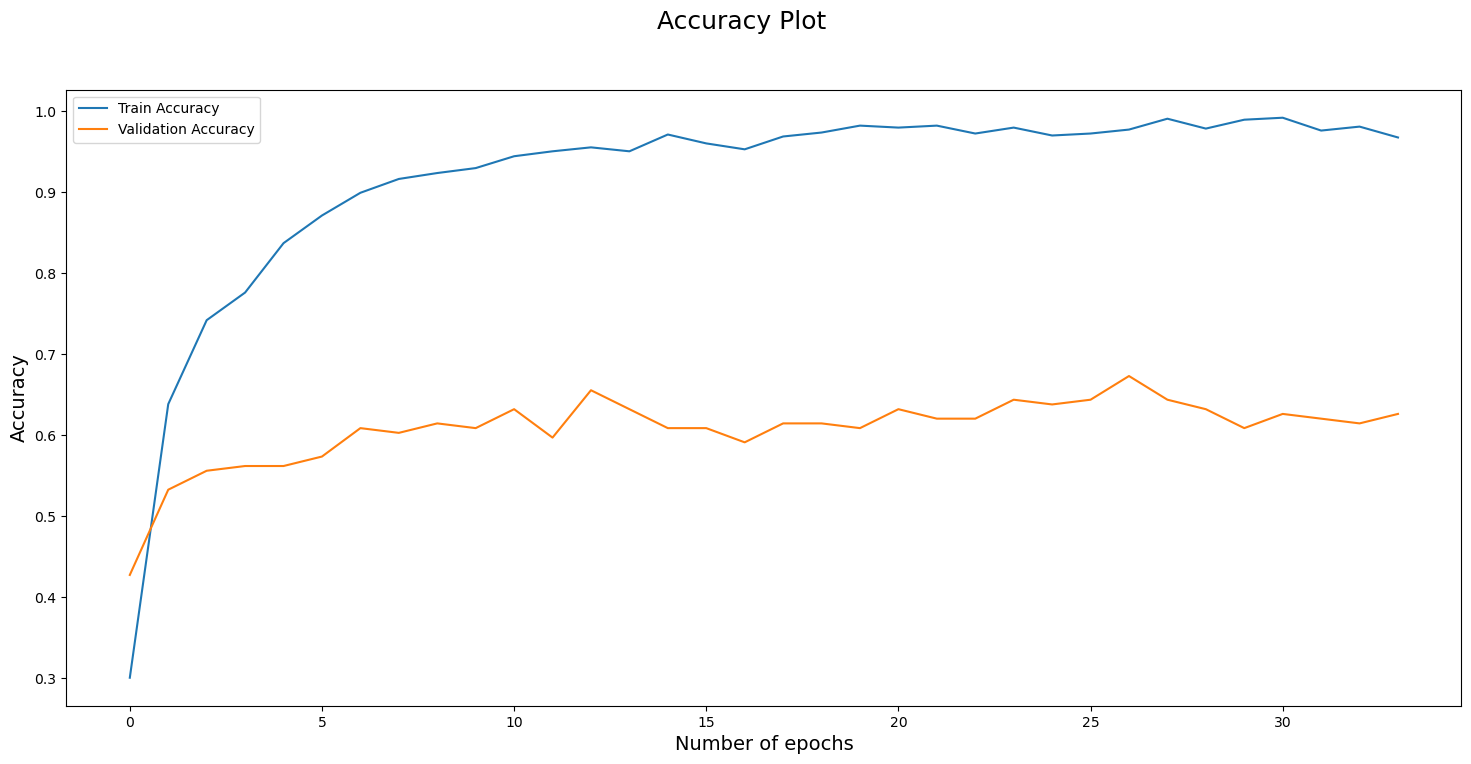

In [22]:
plt.figure(figsize=(18,8))

plt.suptitle('Accuracy Plot', fontsize=18)

plt.plot(clf.history['accuracy'], label='Train Accuracy')
plt.plot(clf.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

Text(0, 0.5, 'Loss')

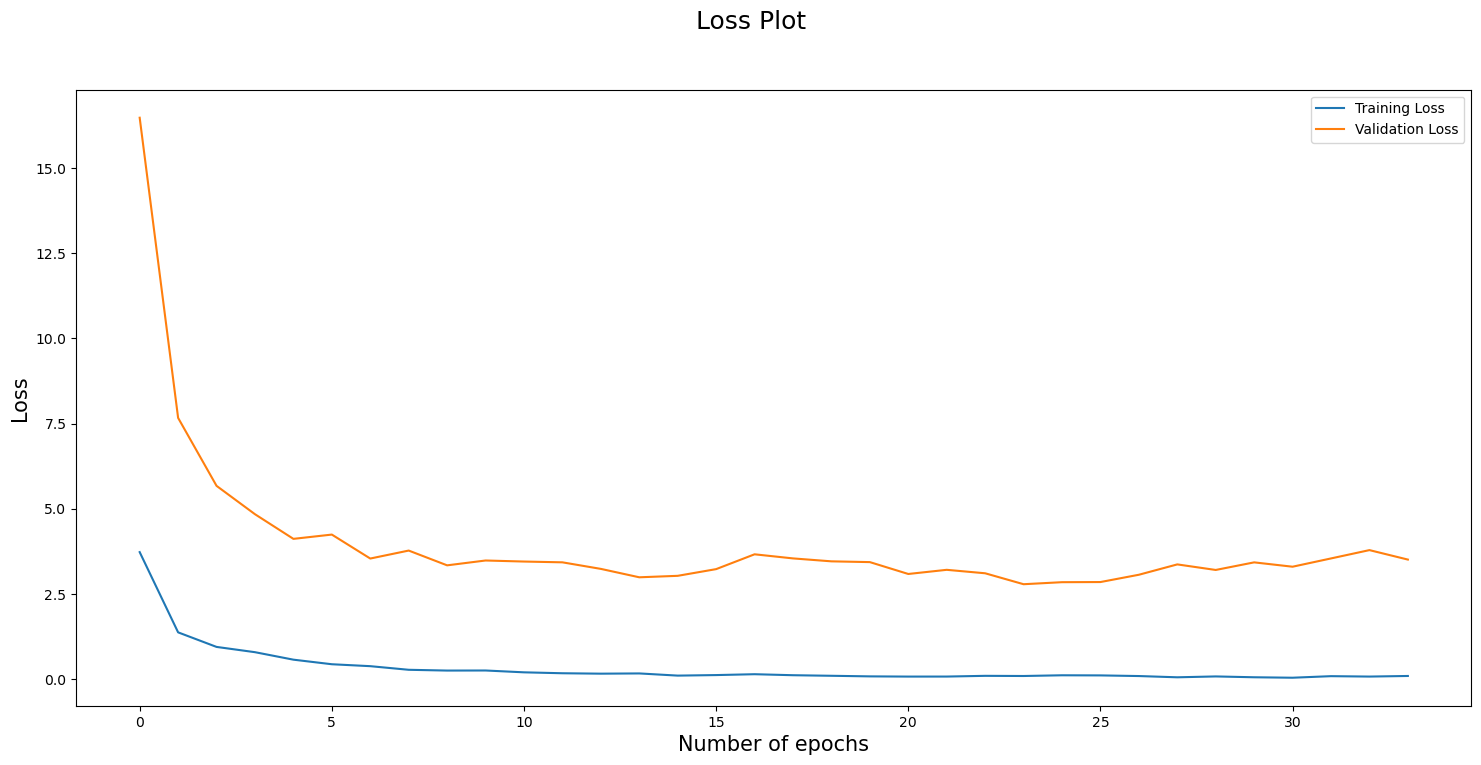

In [23]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss Plot', fontsize=18)
plt.plot(clf.history['loss'], label='Training Loss')
plt.plot(clf.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

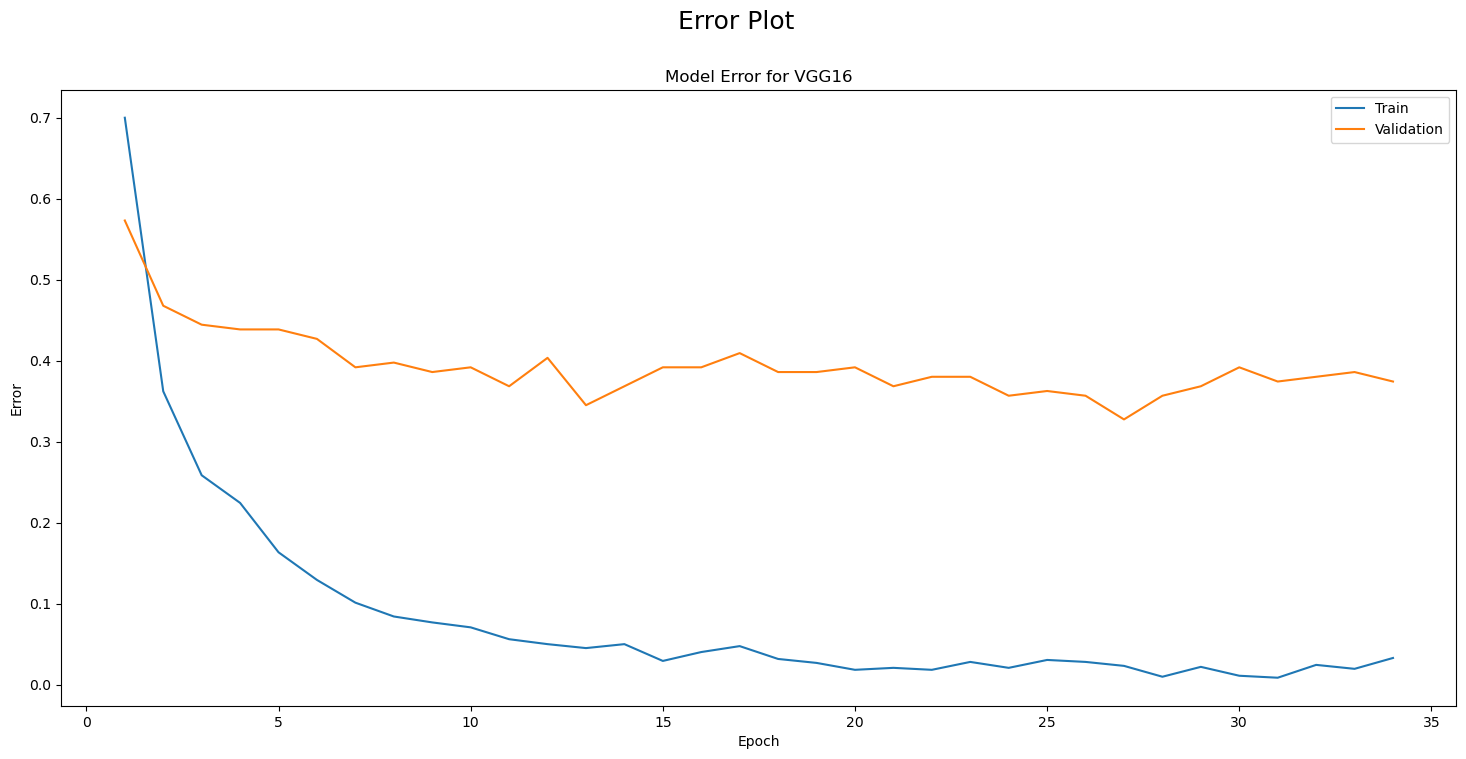

In [24]:
plt.figure(figsize=(18,8))

plt.suptitle('Error Plot', fontsize=18)

a=[1-x for x in clf.history['accuracy']]
b=[1-x for x in clf.history['val_accuracy']]

plt.plot(range(1,len(a)+1),a)
plt.plot(range(1,len(b)+1),b)
plt.title('Model Error for VGG16')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [25]:
predictions = np.argmax(model.predict(test_values), axis=-1)

10/10 [==============================] - 20s 2s/step


In [26]:
test_values.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
      dtype=int32)

In [27]:
predictions

array([ 0,  3,  0,  0, 11,  0,  0,  9, 12,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2, 18,  2,  2,  2,  2,  2,  2,  2,  3,  0,  3,  3,  3,  3,  3,
        6,  3,  3, 15,  4,  4,  4, 18,  3,  4,  4,  4,  5,  5,  5, 10,  4,
       15,  5,  5, 18,  6, 18,  6,  2,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7, 16,  8,  8,  8,  8,  8,  8,  6,  8,  8,  9,  9,  9,
        7,  9,  9,  9,  9,  9, 10, 10,  6, 18, 15,  8, 10, 10,  1, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 13, 12, 12, 12, 12,  8, 12, 17, 12, 14,
       13, 12, 13, 14,  3, 14, 17, 13, 14, 13, 14, 14, 14, 14, 14, 17, 14,
       15,  2, 11,  6, 18, 15, 15, 15, 15,  8, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 10, 12, 17, 17,  4, 12,  8, 17, 13, 12, 18, 18, 18,
       18, 18, 19, 18, 18, 18, 19, 18, 19, 18, 18, 18, 18, 19, 18])

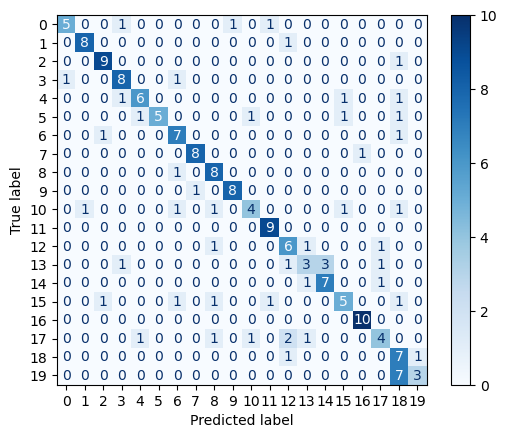

In [28]:
res_cm = confusion_matrix(test_values.classes, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix=res_cm) 
disp.plot(cmap=plt.cm.Blues) 
plt.show()

In [29]:
print(classification_report(test_values.classes, predictions))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.89      0.89      0.89         9
           2       0.82      0.90      0.86        10
           3       0.73      0.80      0.76        10
           4       0.75      0.67      0.71         9
           5       1.00      0.56      0.71         9
           6       0.64      0.78      0.70         9
           7       0.89      0.89      0.89         9
           8       0.67      0.89      0.76         9
           9       0.89      0.89      0.89         9
          10       0.67      0.44      0.53         9
          11       0.82      1.00      0.90         9
          12       0.55      0.67      0.60         9
          13       0.50      0.33      0.40         9
          14       0.70      0.78      0.74         9
          15       0.62      0.50      0.56        10
          16       0.91      1.00      0.95        10
          17       0.57    

#### EfficientNetB0

In [30]:
effnet = EfficientNetB0(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

for layer in effnet.layers:
    layer.trainable=False

model1 = tf.keras.models.Sequential([
        effnet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='softmax')
])

In [31]:
model1.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

In [32]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_6 (Bat  (None, 62720)             250880    
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 62720)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              64226304  
                                                                 
 batch_normalization_7 (Bat  (None, 1024)             

In [33]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, restore_best_weights=True)

In [34]:
clf1=model1.fit(train_values,epochs=100,callbacks=[early_stop],validation_data=(val_values),batch_size=20)

Epoch 1/100
41/41 [==============================] - 66s 1s/step - loss: 3.4830 - accuracy: 0.3598 - precision_2: 0.4038 - recall_2: 0.3098 - val_loss: 1.7196 - val_accuracy: 0.6608 - val_precision_2: 0.7000 - val_recall_2: 0.6550
Epoch 2/100
41/41 [==============================] - 55s 1s/step - loss: 1.1891 - accuracy: 0.6866 - precision_2: 0.7595 - recall_2: 0.6354 - val_loss: 0.9351 - val_accuracy: 0.7485 - val_precision_2: 0.7736 - val_recall_2: 0.7193
Epoch 3/100
41/41 [==============================] - 56s 1s/step - loss: 0.6382 - accuracy: 0.8085 - precision_2: 0.8577 - recall_2: 0.7573 - val_loss: 0.8216 - val_accuracy: 0.7544 - val_precision_2: 0.8176 - val_recall_2: 0.7076
Epoch 4/100
41/41 [==============================] - 56s 1s/step - loss: 0.4611 - accuracy: 0.8500 - precision_2: 0.8915 - recall_2: 0.8220 - val_loss: 0.8225 - val_accuracy: 0.7661 - val_precision_2: 0.8105 - val_recall_2: 0.7251
Epoch 5/100
41/41 [==============================] - 58s 1s/step - loss: 0.4

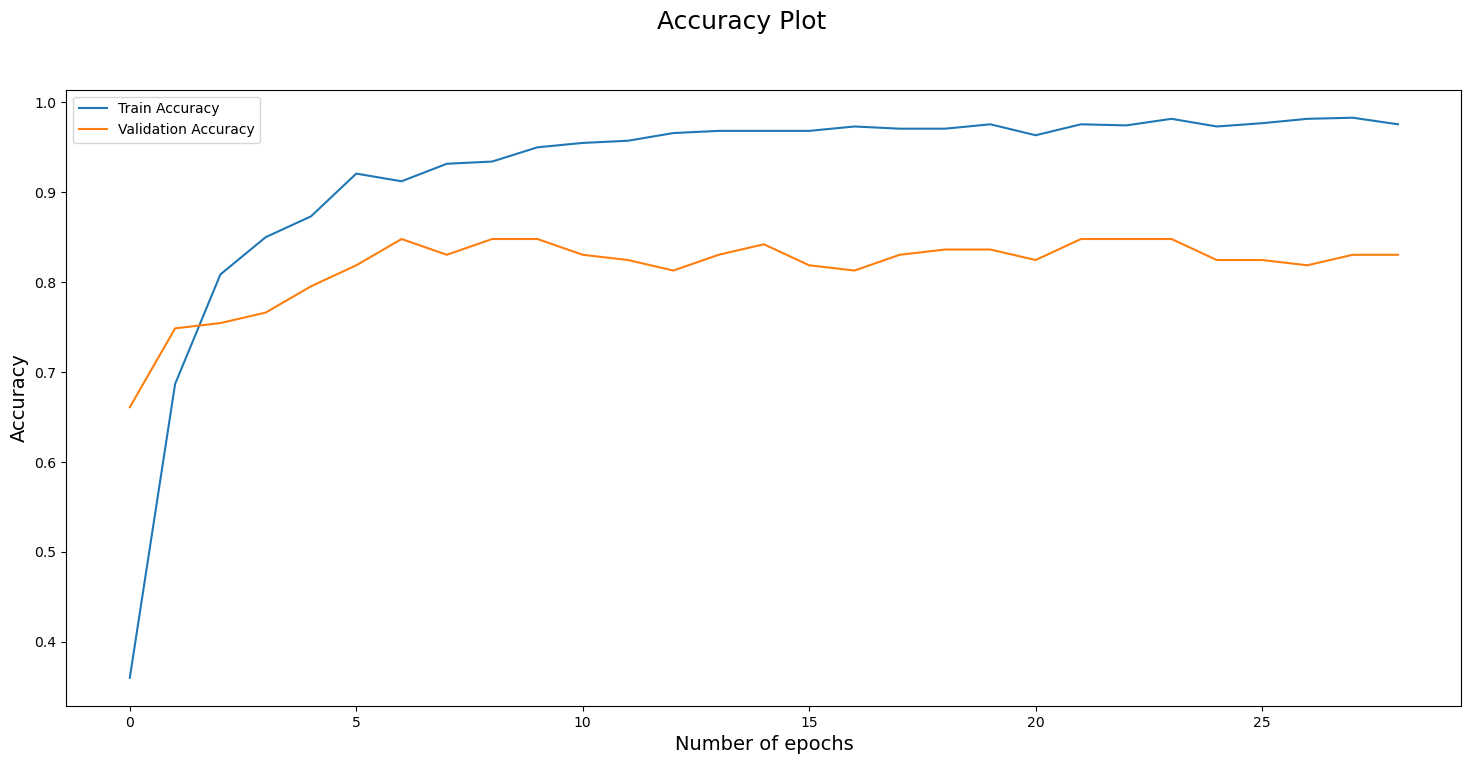

In [35]:
plt.figure(figsize=(18,8))

plt.suptitle('Accuracy Plot', fontsize=18)

plt.plot(clf1.history['accuracy'], label='Train Accuracy')
plt.plot(clf1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

Text(0, 0.5, 'Loss')

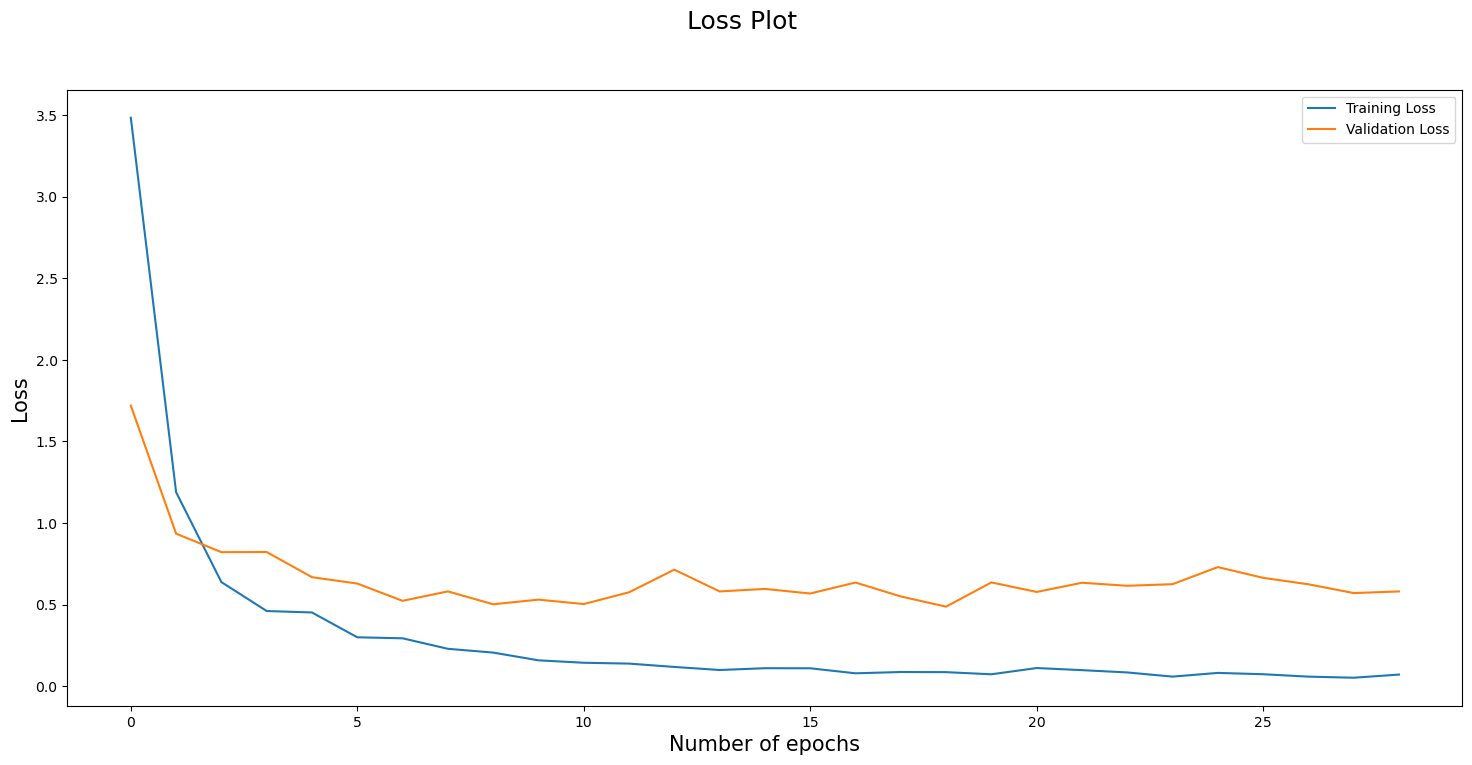

In [36]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss Plot', fontsize=18)
plt.plot(clf1.history['loss'], label='Training Loss')
plt.plot(clf1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

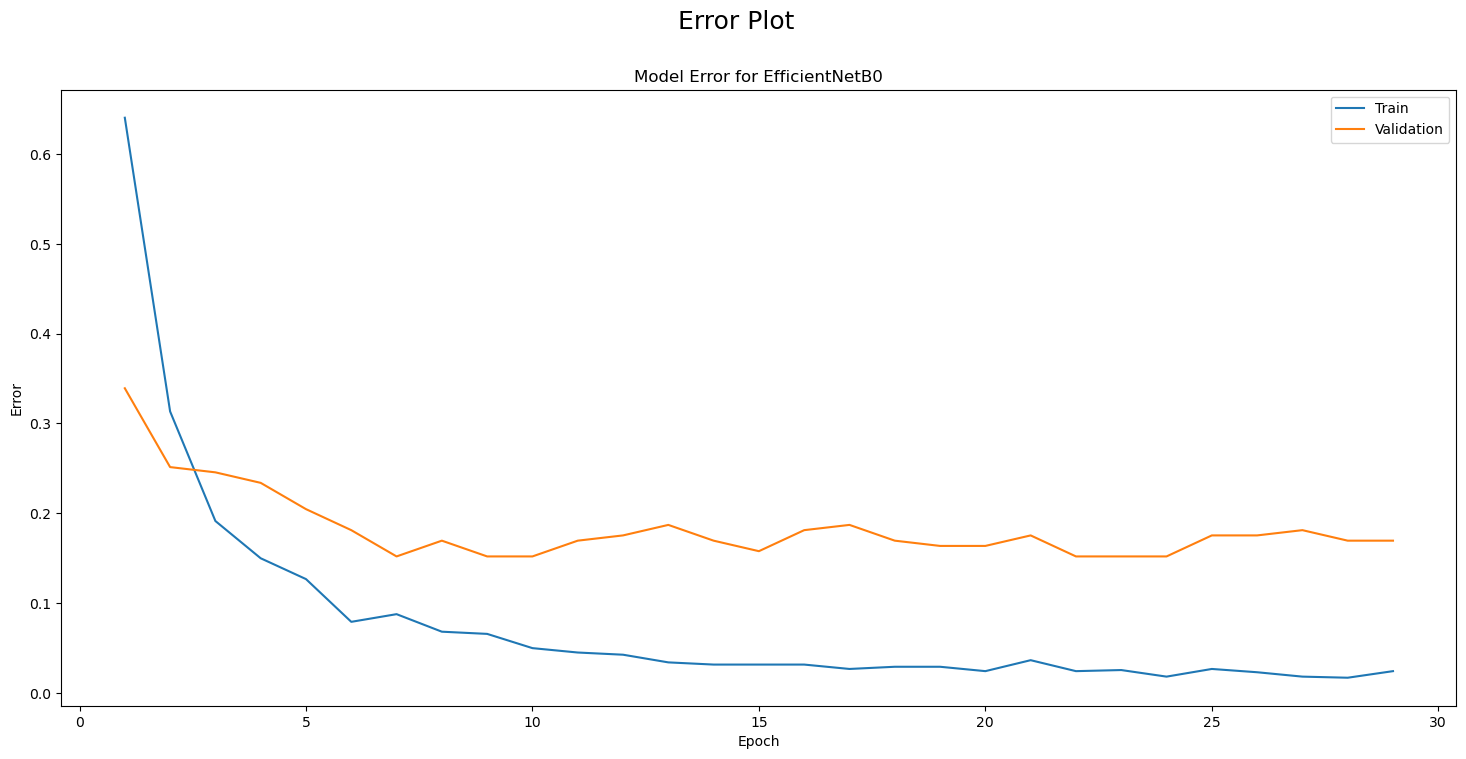

In [37]:
plt.figure(figsize=(18,8))

plt.suptitle('Error Plot', fontsize=18)

a=[1-x for x in clf1.history['accuracy']]
b=[1-x for x in clf1.history['val_accuracy']]

plt.plot(range(1,len(a)+1),a)
plt.plot(range(1,len(b)+1),b)
plt.title('Model Error for EfficientNetB0')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [38]:
predictions1 = np.argmax(model1.predict(test_values), axis=-1)

10/10 [==============================] - 7s 553ms/step


In [39]:
print(classification_report(test_values.classes, predictions1))

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       1.00      0.89      0.94         9
           2       0.83      1.00      0.91        10
           3       0.80      0.80      0.80        10
           4       0.75      0.67      0.71         9
           5       1.00      0.67      0.80         9
           6       1.00      1.00      1.00         9
           7       0.82      1.00      0.90         9
           8       0.82      1.00      0.90         9
           9       0.89      0.89      0.89         9
          10       0.89      0.89      0.89         9
          11       1.00      1.00      1.00         9
          12       0.90      1.00      0.95         9
          13       0.86      0.67      0.75         9
          14       0.78      0.78      0.78         9
          15       0.75      0.60      0.67        10
          16       0.83      1.00      0.91        10
          17       0.82    

In [40]:
predictions1

array([ 0,  0,  0,  0,  3,  0,  8,  7,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  7,  3,  0,
        3,  3,  3, 15,  4,  4,  4,  4,  0,  4, 15,  4,  5,  5,  5, 10,  5,
        4,  5,  2,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
       16,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,  9, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14,
       13, 13, 13, 13, 13, 14, 17, 13, 14, 17, 14, 13, 14, 14, 14, 14, 14,
       15,  4,  3,  8, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 12, 17, 17, 17, 17, 17, 18, 18, 18, 19,
       18, 18, 19, 18, 18, 19, 18, 19, 19, 19, 19, 19, 19, 19, 19])

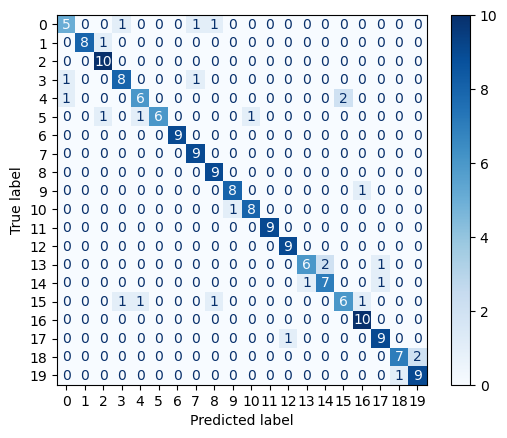

In [41]:
res_cm = confusion_matrix(test_values.classes, predictions1) 
disp = ConfusionMatrixDisplay(confusion_matrix=res_cm) 
disp.plot(cmap=plt.cm.Blues) 
plt.show()